In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
%config InlineBackend.figure_format = 'retina'

In [2]:
# task 
def task(amplitude=1.0, frequency=1.0, n_points=400):
    x = torch.linspace(-2.0, 2.0, n_points)
    y = amplitude*torch.sin(2*torch.pi*frequency*x)
    return x.reshape(-1, 1), y
    

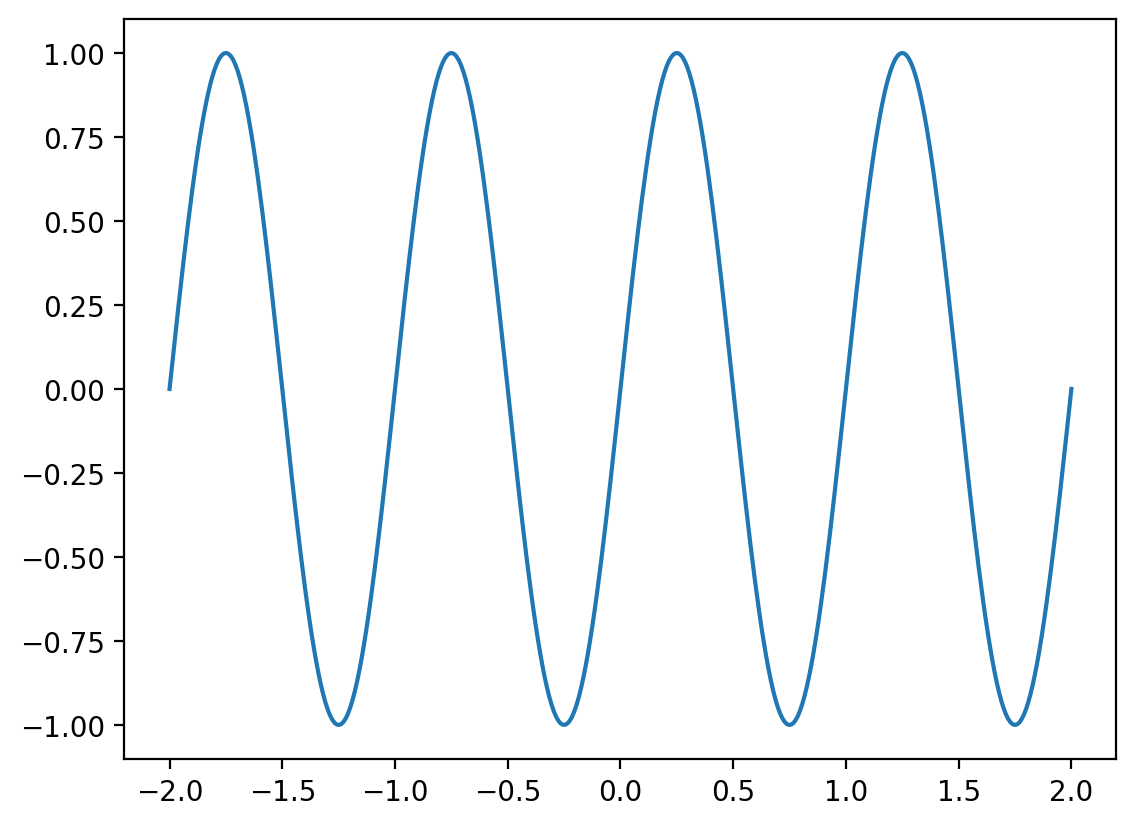

In [3]:
x, y = task()
plt.plot(x, y)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size = 1, hidden_size=10, representation_size=5):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_size + 1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, representation_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [5]:
def create_context(x, y):
    """
    x: (n, d)
    y: (n,)
    ---
    output:
    c: (n, d+1)
    """
    return torch.cat((x, y.reshape(-1, 1)), dim=1)


In [6]:
ctx = create_context(x, y)

In [7]:
representation_size = 5

In [8]:
enc = Encoder(representation_size=representation_size)
representation = enc(ctx)
representation_mean = representation.mean(dim=0)
print(representation_mean.shape)

torch.Size([5])


In [9]:
class Decoder(nn.Module):
    def __init__(self, input_size = 1, hidden_size=10, representation_size=5):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(representation_size + input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = x.ravel()
        return x

In [10]:
dec = Decoder(representation_size=representation_size)

In [11]:
repeated_representation = representation_mean.repeat(len(x), 1)
repeated_representation

tensor([[-0.1554,  0.1063, -0.0408, -0.1532, -0.0355],
        [-0.1554,  0.1063, -0.0408, -0.1532, -0.0355],
        [-0.1554,  0.1063, -0.0408, -0.1532, -0.0355],
        ...,
        [-0.1554,  0.1063, -0.0408, -0.1532, -0.0355],
        [-0.1554,  0.1063, -0.0408, -0.1532, -0.0355],
        [-0.1554,  0.1063, -0.0408, -0.1532, -0.0355]],
       grad_fn=<RepeatBackward0>)

In [12]:
decoder_inp = torch.cat((x, repeated_representation), dim=1)
decoder_inp.shape

torch.Size([400, 6])

In [13]:
dec(decoder_inp).shape

torch.Size([400])

In [14]:
# Train/test split

x, y = task(n_points=2000)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_x, test_x, train_y, test_y = train_test_split(x, y)

In [17]:
train_x.shape, test_x.shape

(torch.Size([1500, 1]), torch.Size([500, 1]))

In [18]:
def get_context_target(train_x, train_y, ctx_points):
    #torch.manual_seed(0)
    idx = torch.randperm(len(train_x))
    context_idx = idx[:ctx_points]
    context_x = train_x[context_idx]
    context_y = train_y[context_idx]
    
    target_idx = idx[ctx_points:]
    
    target_x = train_x[target_idx]
    target_y = train_y[target_idx]
    return context_x, context_y, target_x, target_y

In [30]:
n_epochs = 2000
ctx_points = 1000
target_points = len(x)*0.25
representation_size = 4
hidden_size = 30
enc = Encoder(representation_size=representation_size, hidden_size=hidden_size)
dec = Decoder(representation_size=representation_size, hidden_size=hidden_size)


params = list(enc.parameters()) + list(dec.parameters())

optimizer = torch.optim.Adam(params, lr=3e-3)

for i in range(n_epochs):
    context_x, context_y, target_x, target_y = get_context_target(train_x, train_y, ctx_points)
    ctx = create_context(context_x, context_y)
    representation = enc(ctx)
    representation_mean = representation.mean(dim=0)
    
    repeated_representation = representation_mean.repeat(len(target_x), 1)
    decoder_inp = torch.cat((target_x, repeated_representation), dim=1)
    
    yhat = dec(decoder_inp)
    
    loss = nn.MSELoss()(yhat, target_y)
    if i%100==0:
        print(i, loss.item())
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()


0 0.5121781229972839
100 0.39759519696235657
200 0.25660619139671326
300 0.14657656848430634
400 0.06448779255151749
500 0.04326537624001503
600 0.021076882258057594
700 0.015273225493729115
800 0.010952409356832504
900 0.009423683397471905
1000 0.006264188792556524
1100 0.0054198820143938065
1200 0.004422122146934271
1300 0.0035493236500769854
1400 0.0030960990116000175
1500 0.0022987055126577616
1600 0.0020124774891883135
1700 0.002914207987487316
1800 0.003236218122765422
1900 0.002254761289805174


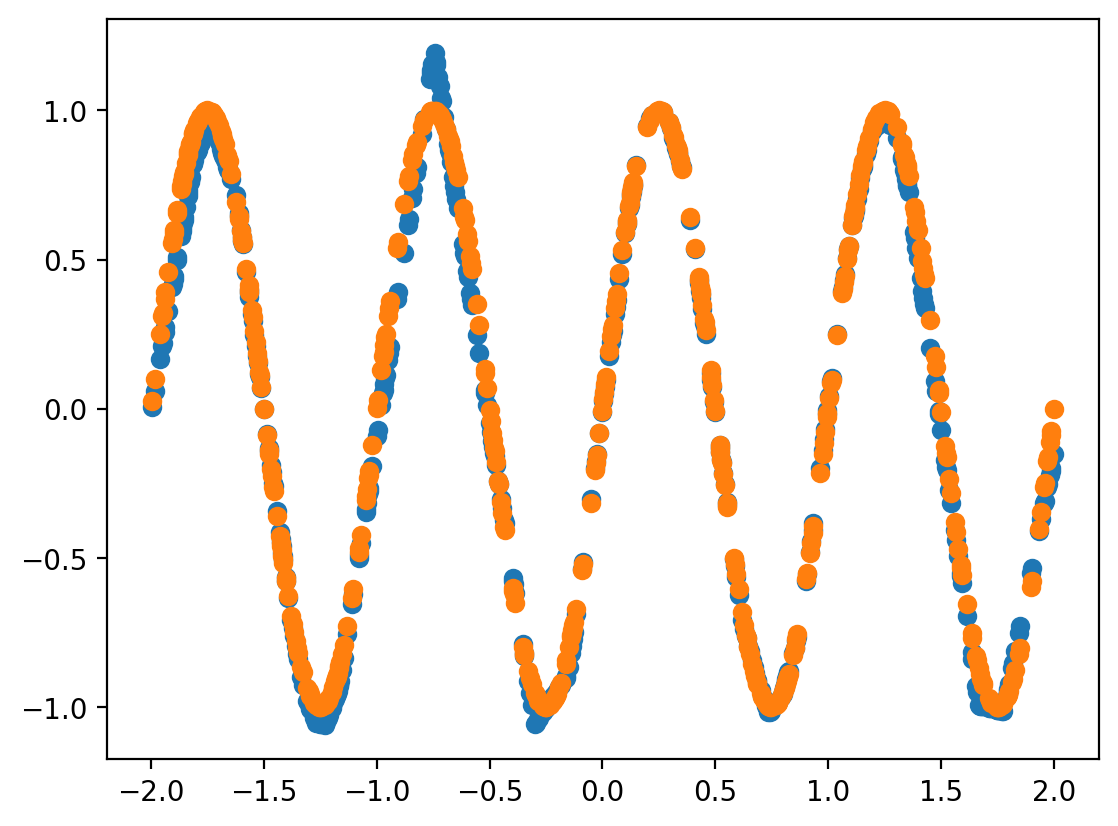

In [31]:
plt.scatter(target_x.detach().numpy(), yhat.detach().numpy() )
plt.scatter(target_x.detach().numpy(), target_y.detach().numpy())

In [25]:
representation_mean

tensor([-0.7204, -0.9697, -1.2259, -0.3359], grad_fn=<MeanBackward1>)